# Getting Started with `bw_timex`

Here's a rundown of the steps involved in a `TimexLCA`:

<div style="display: flex; justify-content: center; background-color: white; padding: 10px; width: 45%; margin: auto;">
  <img src="data/method.svg" style="border-radius: 15px; width: 100%;">
</div>

Let's walk through steps 1-4 considering a very simple dummy system:

```mermaid
flowchart LR
subgraph background[<i>background</i>]
    B("Process B"):::bg
end

subgraph foreground[<i>foreground</i>]
    A("Process A"):::fg
end

subgraph biosphere[<i>biosphere</i>]
    CO2("CO2"):::bio
end

B-->|"3 kg"|A
A-.->|"5 kg"|CO2
B-.->|"11 kg"|CO2

classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef bio color:#222832, fill:#9c5ffd, stroke:none;
style background fill:none, stroke:none;
style foreground fill:none, stroke:none;
style biosphere fill:none, stroke:none;
```

The production system above is our "static system model", which we now set up with brightway:

In [1]:
# Create static system model

import bw2data as bd

bd.projects.set_current("getting_started_with_timex")

bd.Database("biosphere").write(
    {
        ("biosphere", "CO2"): {
            "type": "emission",
            "name": "CO2",
        },
    }
)

bd.Database("background_2020").write(
    {
        ("background_2020", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background_2020", "B"),
                },
                {
                    "amount": 11,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                },
            ],
        },
    }
)

bd.Database("foreground").write(
    {
        ("foreground", "A"): {
            "name": "A",
            "location": "somewhere",
            "reference product": "A",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("foreground", "A"),
                },
                {
                    "amount": 3,
                    "type": "technosphere",
                    "input": ("background_2020", "B"),
                },
                {
                    "amount": 5,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                }
            ],
        },
    }
)

bd.Method(("our", "method")).write(
    [
        (("biosphere", "CO2"), 1),
    ]
)

100%|██████████| 1/1 [00:00<00:00, 6374.32it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 24244.53it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 22192.08it/s]

Vacuuming database 


We also need a prospective database. Let's say our original background system represents the year 2020, where process B emitts 11 kg CO2. By 2030, process B only emitts 7 kg CO2. We write this new process to a separate database:

In [2]:
# Write prospective database for 2030

bd.Database("background_2030").write(
    {
        ("background_2030", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background_2030", "B"),
                },
                {
                    "amount": 7,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                },
            ],
        },
    }
)

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]

Vacuuming database 


> **Note:** It does not matter where your prospective data comes from - you can also use [premise](https://premise.readthedocs.io/en/latest/introduction.html).

To save the information which background database represents which year, we define a `database_dates`:

In [3]:
from datetime import datetime

database_dates = {
    "background_2020": datetime.strptime("2020", "%Y"),
    "background_2030": datetime.strptime("2030", "%Y"),
    "foreground": "dynamic", # no specific point in time, but should be "distributed over time"
}

## Step 1 - Adding temporal information

Temporal information on the exchange level is carried by [`TemporalDistribution`](https://docs.brightway.dev/projects/bw-temporalis/en/stable/content/api/bw_temporalis/temporal_distribution/index.html#bw_temporalis.temporal_distribution.TemporalDistribution) objects, originally introduced by [`bw_temporalis`](https://github.com/brightway-lca/bw_temporalis). 

A `TemporalDistribution` tells you what share of an exchange (*amount array*) happens at what point in time (*dates array*). 


Making up some temporal information:

```mermaid
flowchart LR
subgraph background[" "]
    B_2020("Process B"):::bg
end

subgraph foreground[" "]
    A("Process A"):::fg
end

subgraph biosphere[" "]
    CO2("CO2"):::b
end

B_2020-->|"dates:[-2, 0, +4] years\n amounts: [0.3, 0.5, 0.2] * 3 kg" |A
A-.->|"dates: [0, +1] years \n amounts: [0.6, 0.4] * 5 kg"|CO2
B_2020-.->|11 kg|CO2

classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef b color:#222832, fill:#9c5ffd, stroke:none;
style foreground fill:none, stroke:none;
style background fill:none, stroke:none;
style biosphere fill:none, stroke:none;

```

Pouring this into a `TemporalDistribution`:

In [4]:
import numpy as np
from bw_temporalis import TemporalDistribution

td_b_to_a = TemporalDistribution(
    date=np.array([-2, 0, 4], dtype="timedelta64[Y]"),
    amount=np.array([0.3, 0.5, 0.2]),
)

/Users/timodiepers/anaconda3/envs/timex_env1/lib/python3.11/site-packages/bw2calc/__init__.py:45: UserWarning: 
It seems like you have an ARM architecture, but haven't installed scikit-umfpack:

    https://pypi.org/project/scikit-umfpack/

Installing it could give you much faster calculations.

  warnings.warn(UMFPACK_WARNING)


Now we add this `TemporalDistribution` to the corresponding exchange:

In [5]:
from bw_timex.utils import add_temporal_distribution_to_exchange

add_temporal_distribution_to_exchange(
    temporal_distribution=td_b_to_a, 
    input_code="B", 
    input_database="background_2020",
    output_code="A",
    output_database="foreground"
)

The same for the exchange between A and CO2:

In [6]:
td_a_to_co2 = TemporalDistribution(
    date=np.array([0, 1], dtype="timedelta64[Y]"),
    amount=np.array([0.6, 0.4]),
)

# We actually only have to define enough fields to uniquely identify the exchange here
add_temporal_distribution_to_exchange(
    temporal_distribution=td_a_to_co2, 
    input_code="CO2", 
    output_code="A"
)

## Step 2 - Building the process timeline 

Now we can instantiate a `TimexLCA` object - similarly to a normal Brightway LCA object, but with the additional argument of our `database_dates`.

Our demand will be the product of process A:

In [7]:
from bw_timex import TimexLCA

tlca = TimexLCA(
    demand={("foreground", "A"): 1},
    method=("our", "method"),
    database_dates=database_dates,
)

Building the process timeline is very simple now. To define when the demand occurs, you can specify a `starting_datetime` (default is "now"):

In [8]:
tlca.build_timeline(starting_datetime="2024-01-01")

Starting graph traversal
Calculation count: 1


/Users/timodiepers/anaconda3/envs/timex_env1/lib/python3.11/site-packages/bw_timex/timex_lca.py:213: UserWarning: No edge filter function provided. Skipping all edges in background databases.
  warnings.warn(


,date_producer,producer_name,date_consumer,consumer_name,amount,temporal_market_shares
0,2022-01-01,B,2024-01-01,A,0.9,"{'background_2020': 0.8, 'background_2030': 0.2}"
1,2024-01-01,B,2024-01-01,A,1.5,"{'background_2020': 0.6, 'background_2030': 0.4}"
2,2024-01-01,A,2024-01-01,-1,1.0,None
3,2028-01-01,B,2024-01-01,A,0.6,"{'background_2020': 0.2, 'background_2030': 0.8}"


The timeline tells us which exchange happens at what time. 

Also, we see the "temporal_market_shares", already giving a hint on how the processes will be re-linked in the next step. For the first row of the timeline, the interpolation weights are:

In [9]:
tlca.timeline.temporal_market_shares[0]

{'background_2020': 0.8, 'background_2030': 0.2}

## Step 3 - Calculating the time-explicit LCI

Calculating the time-explicit LCI from the timeline is very simple, at least from the user perspective:


In [10]:
tlca.lci()

/Users/timodiepers/anaconda3/envs/timex_env1/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Under the hood, before solving the inventory problem, we're re-build the technosphere and biosphere matrices here. More specifically, we add new rows and columns to carry the extra temporal information. Details are explained in the [Theory Section](https://docs.brightway.dev/projects/bw-timex/en/latest/content/theory.html#modifying-the-matrices) of our docs.

## Step 4 - Impact assessment

The impact assessment can be very simple now. To characterize the inventory with the impact assessment method that we initially chose when creating our `TimexLCA`, we can simply call:

In [11]:
tlca.static_lcia()
tlca.static_score

32.959999999999994

But there's more: Because a `TimexLCA` retains temporal information in the inventory, it also allows for dynamic characterization. To help with that, we created another package, simply called [`dynamic_characterization`](https://dynamic-characterization.readthedocs.io/en/latest/). This is not today's topic, but here's a quick demo:

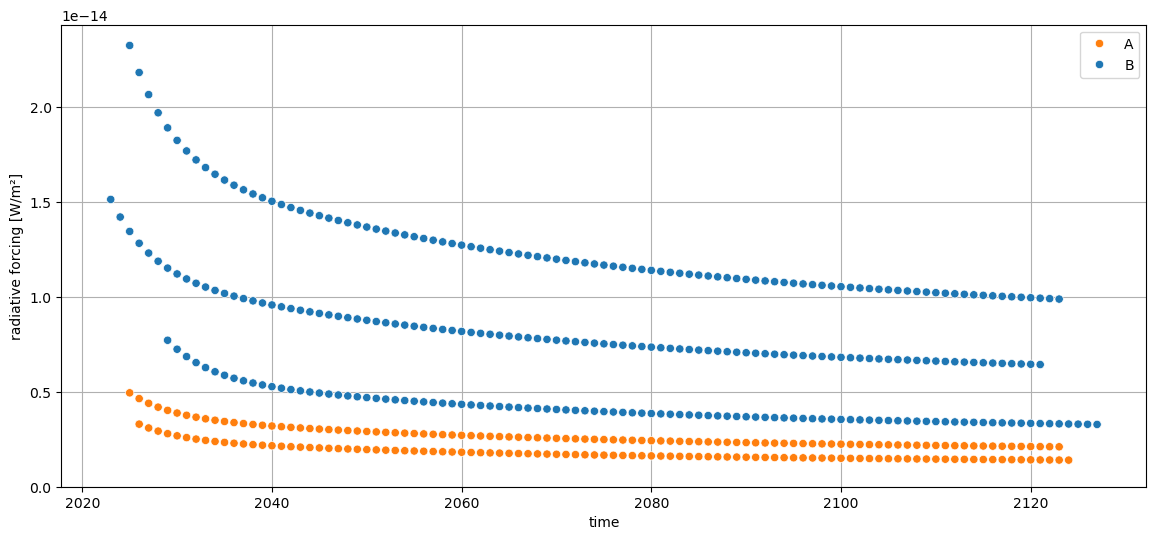

In [12]:
from dynamic_characterization.ipcc_ar6 import characterize_co2 # <- dynamic characterization function
emission_id = bd.get_activity(("biosphere", "CO2")).id

# defining which characterization function to use for which emission
characterization_functions = {
    emission_id: characterize_co2,
}

# characterizing the inventory
tlca.dynamic_lcia(
    metric="radiative_forcing",
    time_horizon=100,
    characterization_functions=characterization_functions,
)

tlca.plot_dynamic_characterized_inventory()

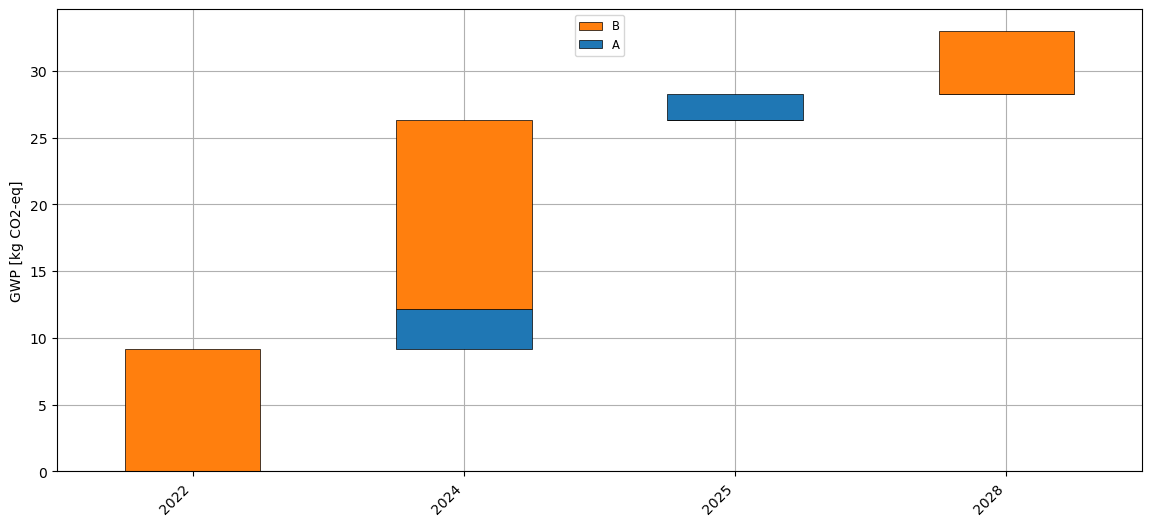

In [13]:
from bw_timex.utils import plot_characterized_inventory_as_waterfall

tlca.dynamic_lcia(
    metric="GWP",
    time_horizon=100,
    characterization_functions=characterization_functions,
)

plot_characterized_inventory_as_waterfall(tlca)


## Quick Recap
This might have seemed quite lengthy now. But essentially, calculating a `TimexLCA` is just this:

In [14]:
tlca = TimexLCA(
    demand={("foreground", "A"): 1},
    method=("our", "method"),
    database_dates=database_dates,
)
tlca.build_timeline()
tlca.lci()
tlca.static_lcia()
tlca.static_score

Starting graph traversal
Calculation count: 1


/Users/timodiepers/anaconda3/envs/timex_env1/lib/python3.11/site-packages/bw_timex/timex_lca.py:213: UserWarning: No edge filter function provided. Skipping all edges in background databases.
  warnings.warn(
/Users/timodiepers/anaconda3/envs/timex_env1/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


31.759999999999994

For most of the functions we used here, there are numerous optional arguments and settings you can tweak. We explore some of them in our other [Examples](https://docs.brightway.dev/projects/bw-timex/en/latest/content/examples/index.html), but when in doubt: Our code is pretty well documented, see our [API Reference](https://docs.brightway.dev/projects/bw-timex/en/latest/content/api/index.html) - so please browse through that as needed ☀️